#### GINI and GDP data for WDVP

In [1]:
import pandas as pd # wrangling
import numpy as np # stats
import wget # api call
import zipfile # unzip folders
from scipy import stats # slope
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import geopandas # map

In [2]:
# only need to run this cell once! data download & unzipping
# read in GINI data from WorldBank
URL = "https://api.worldbank.org/v2/en/indicator/SI.POV.GINI?downloadformat=csv"
data_zipped = wget.download(URL)

# unzip
with zipfile.ZipFile(data_zipped,"r") as zip_ref:
    zip_ref.extractall("gini_data")

In [3]:
# read in data
gini_df = pd.read_csv('gini_data/API_SI.POV.GINI_DS2_en_csv_v2_4770433.csv', skiprows=[0,1,2])

# keep only data for the most recent 10 years (starting 2020 because 2021 only has one observation)
print(gini_df['2021'].isna().sum())

col_list = ['Country Name','Country Code','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']

gini_df = gini_df.loc[:, col_list]

265


In [4]:
# group by continent
# countries by continent csv file: found on github
data_country = pd.read_csv('countries_continents.csv')

# get set of countries in list but not in GINI df
diff_list = list(set(data_country['Country']) - set(gini_df['Country Name']))
print(diff_list)

# manually check gini list & country list - some of them are not present but if they are, we want to name them consistently
# tried to do a fuzzy match but it was prone to overcorrection - e.g. Aruba got coded as Cuba:
#gini_df['test'] = gini_df['Country Name'].map(lambda x: difflib.get_close_matches(x, data_country['Country']))

gini_current_list = ['Iran, Islamic Rep.','Egypt, Arab Rep.','Congo, Rep.','Syrian Arab Republic','Russian Federation',"Korea, Dem. People's Rep.",'Brunei Darussalam','Yemen, Rep.','Venezuela, RB',
                     'St. Kitts and Nevis','Lao PDR','St. Lucia','Micronesia, Fed. Sts.','Gambia, The','Congo, Dem. Rep.','Slovak Republic',
                     'St. Vincent and the Grenadines','Kyrgyz Republic','Bahamas, The','Korea, Rep.']
gini_replace_list = ['Iran','Egypt','Republic of the Congo','Syria','Russia','North Korea','Brunei','Yemen','Venezuela',
                     'Saint Kitts and Nevis','Laos','Saint Lucia','Micronesia','The Gambia','Democratic Republic of the Congo','Slovakia',
                     'Saint Vincent and the Grenadines','Krygyzstan','The Bahamas','South Korea']


['Laos', 'Democratic Republic of the Congo', 'The Bahamas', 'Saint Vincent and the Grenadines', 'Palestine', 'Slovakia', 'Kyrgyzstan', 'Egypt', 'Saint Kitts and Nevis', 'Yemen', 'Brunei', 'Venezuela', 'Republic of the Congo', 'The Gambia', 'Syria', 'Iran', 'Micronesia', 'Russia', 'Vatican City', 'Saint Lucia', 'South Korea', 'North Korea']


In [5]:
# function to replace original strings with corresponding updated strings
def text_replace(orig_string, orig_list, replacement_list):
    if orig_string in orig_list:
        string_index = orig_list.index(orig_string)
        updated_string = orig_string.replace(orig_string, replacement_list[string_index])
    else:
        updated_string = orig_string

    return(updated_string)

#data_country['Country'] = data_country.apply(lambda x: text_replace(x['Country'],country_current_list,country_replace_list), axis=1)
gini_df['Country Name'] = gini_df.apply(lambda x: text_replace(x['Country Name'], gini_current_list, gini_replace_list), axis=1)


In [6]:
# check diffs again
diff_list1 = list(set(data_country['Country']) - set(gini_df['Country Name']))
print(diff_list1)

# check the list, we can drop all the non-matching ones at this point.
diff_list2 = list(set(gini_df['Country Name']) - set(data_country['Country']))
print(diff_list2)

# merge with country data
gini_df = gini_df.rename(columns={"Country Name": "Country"})
gini_df = gini_df.merge(data_country,how='left')


['Kyrgyzstan', 'Palestine', 'Vatican City']
['Krygyzstan', 'Curacao', 'Sub-Saharan Africa', 'Early-demographic dividend', 'Pre-demographic dividend', 'Not classified', 'Late-demographic dividend', 'Africa Western and Central', 'Middle income', 'Arab World', 'Sub-Saharan Africa (excluding high income)', 'Low income', 'IDA total', 'North America', 'Gibraltar', 'High income', 'Puerto Rico', 'Europe & Central Asia (IDA & IBRD countries)', 'Isle of Man', 'Latin America & the Caribbean (IDA & IBRD countries)', 'OECD members', 'East Asia & Pacific (IDA & IBRD countries)', 'Greenland', 'IDA only', 'South Asia', 'Africa Eastern and Southern', 'Cayman Islands', 'Guam', 'Bermuda', 'New Caledonia', 'IDA & IBRD total', 'Heavily indebted poor countries (HIPC)', 'Middle East & North Africa (IDA & IBRD countries)', 'Channel Islands', 'Fragile and conflict affected situations', 'West Bank and Gaza', 'Pacific island small states', 'IDA blend', 'Low & middle income', 'Caribbean small states', 'Central Eu

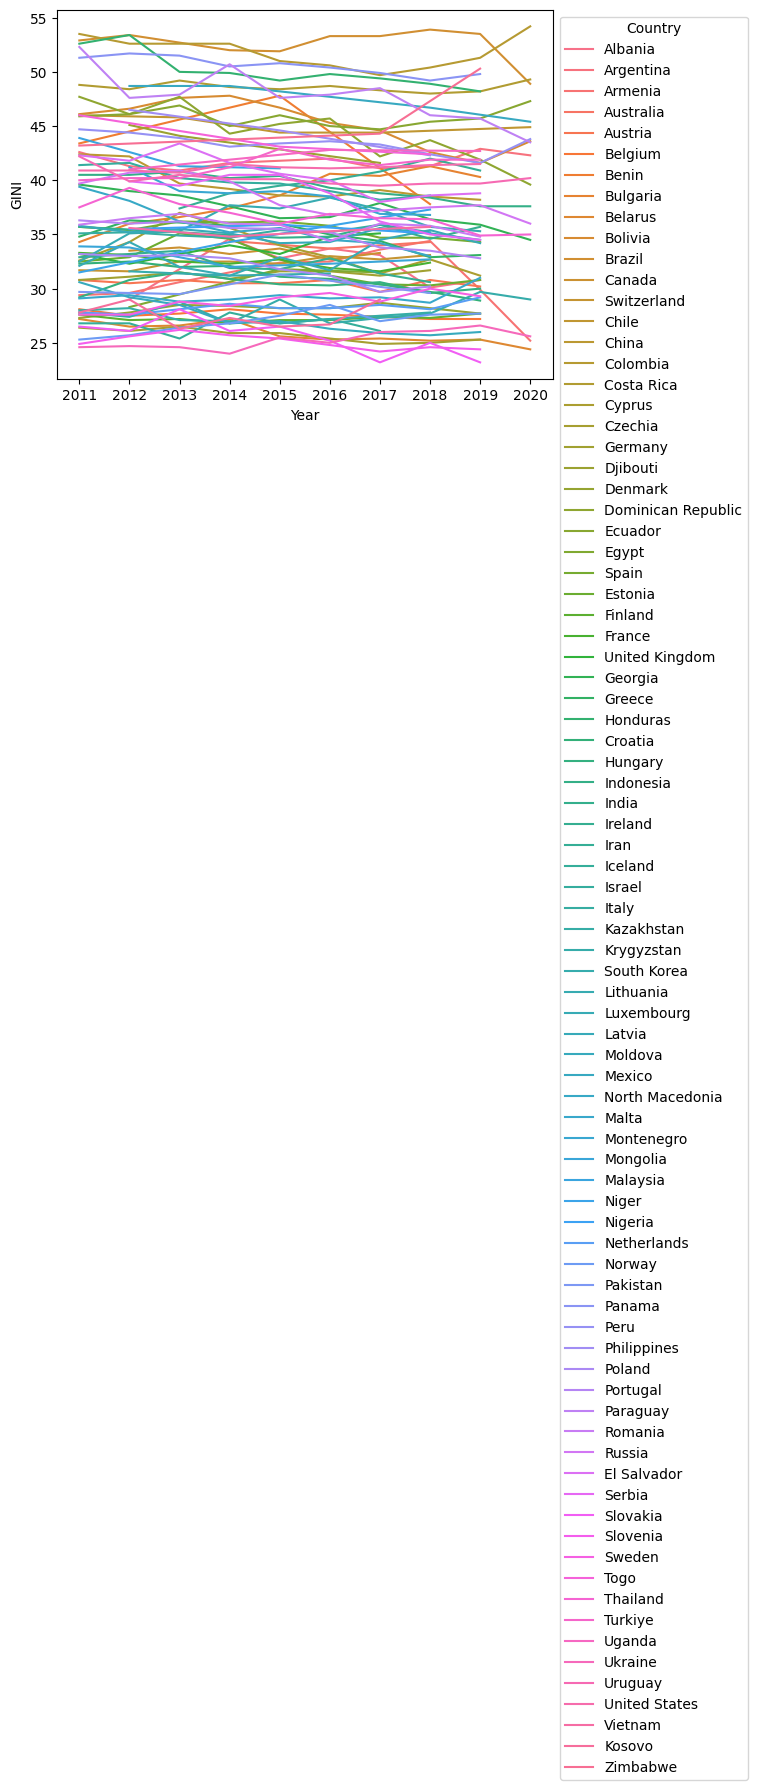

In [7]:
# get number of NaN columns & keep only countries with more than 3 years of data
gini_df['count_na'] = gini_df.isna().sum(axis=1)
gini_select = gini_df[gini_df['count_na'] < 8].drop(columns=['count_na'])

gini_long = pd.melt(gini_select, id_vars=['Country','Continent','Country Code'],var_name='Year',value_name='GINI')

ax = sns.lineplot(data=gini_long, x="Year", y="GINI", hue="Country")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

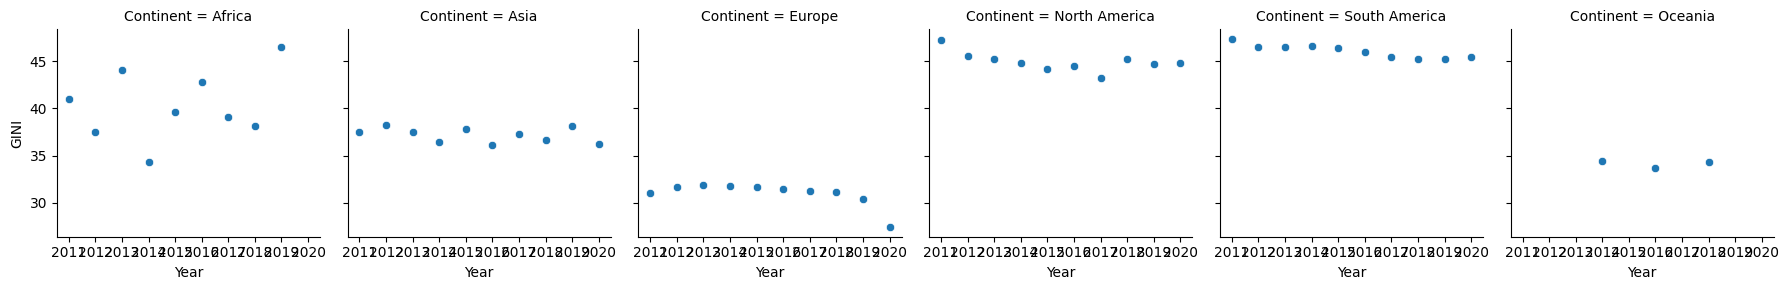

In [8]:
# summary per continent
gini_sum = gini_select.groupby('Continent',dropna=True,as_index=False).agg('mean',numeric_only=True)
gini_sum_long = pd.melt(gini_sum, id_vars='Continent',var_name='Year',value_name='GINI').dropna()

g = sns.FacetGrid(gini_sum_long, col="Continent")
g.map(sns.scatterplot, "Year", "GINI")

In [9]:
# calculate change over time

# have to remove NaNs for slope function
gini_no_na = gini_long.dropna()

# function to extract slope from values
def slope_extract(country_data):
    
    year_data = country_data['Year'].astype('float')
    gini_data = country_data['GINI'].astype('float')
    # linregress (x,y)
    results = stats.linregress(year_data, gini_data)
    slope_val = results.slope

    return(slope_val)

# loop over countries
country_list = gini_no_na['Country'].unique()

# initialize list of slopes
slope_list = []

for country in country_list:
    country_data = gini_no_na[gini_no_na['Country'] == country]
    country_slope = slope_extract(country_data)

    slope_list.append([country_slope, country])

gini_trend = pd.DataFrame(np.row_stack(slope_list), columns = ['GINI_trend','Country'])
# add country code so we can merge with geopandas easily
gini_names = gini_select[['Country','Country Code','Continent']]
gini_trend = gini_trend.merge(gini_names)
gini_trend


,GINI_trend,Country,Country Code,Continent
0,0.05608108108108088,Argentina,ARG,South America
1,-0.06242424242424256,Armenia,ARM,Europe
2,-0.05666666666666676,Austria,AUT,Europe
3,-0.09333333333333355,Belgium,BEL,Europe
4,-0.6972972972972976,Benin,BEN,Africa
...,...,...,...,...
77,-0.8916666666666664,Serbia,SRB,Europe
78,0.2540540540540544,Uganda,UGA,Africa
79,0.040000000000000216,Vietnam,VNM,Asia
80,0.65,Iran,IRN,Asia


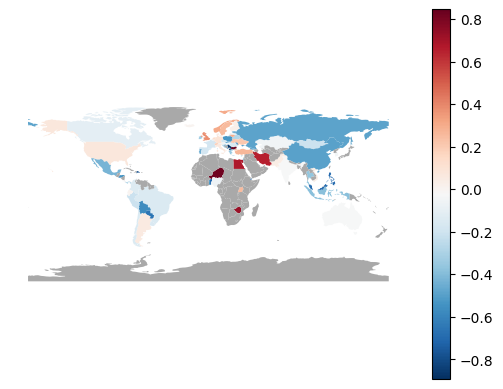

In [10]:
# read in world map from geopandas & merge with GINI data
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world2 = world.merge(gini_trend, left_on='iso_a3',right_on='Country Code', how='left')
# specify numeric, by default it's categorical
world2['GINI_trend'] = pd.to_numeric(world2['GINI_trend'])

fig, ax = plt.subplots(1, 1)

# specify diverging colour scheme: + vs -
ax = world2.plot(column='GINI_trend', ax=ax, legend=True, missing_kwds={'color': 'darkgrey'}, cmap='RdBu_r')
ax.set_axis_off()

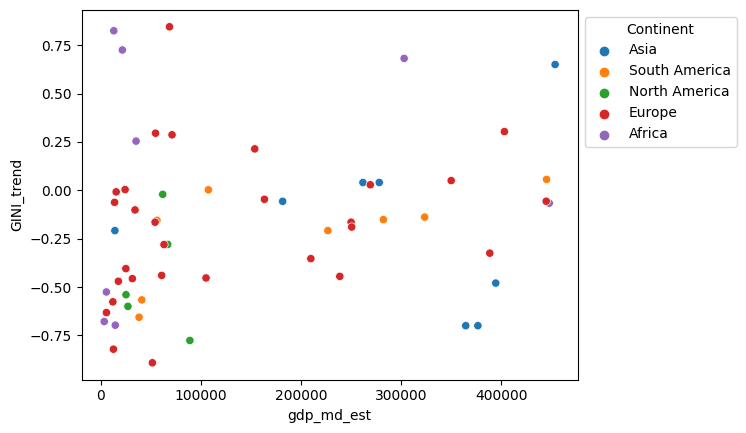

In [11]:
# quick correlation plot between GDP and GINI
# filter out some big values (detected on first visualization) - just to see general trend for other countries
world_filter = world2[world2['gdp_md_est'] < 500000]
g = sns.scatterplot(data=world_filter, x="gdp_md_est", y="GINI_trend", hue = 'Continent')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
